# Download data from Kaggle

In [1]:
!pip install -q kaggle


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
! mkdir ~/.kaggle

mkdir: /Users/andriievskyi/.kaggle: File exists


In [3]:
! cp ../kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [7]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


# Imports

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import string

# Very basic EDA

In [9]:
# Read the data
data = pd.read_csv("/content/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


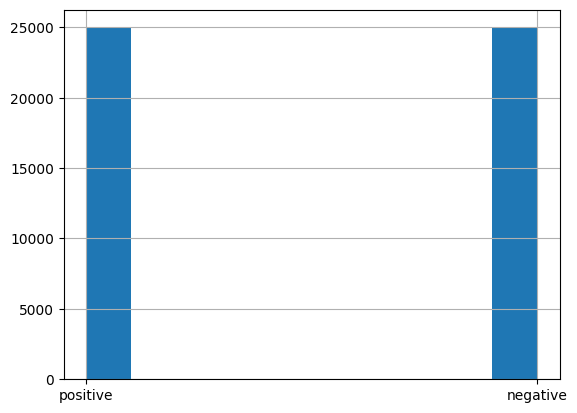

In [10]:
data["sentiment"].hist(); # The dataset is balanced

In [11]:
# Compute the lengths of all reviews
lengths = [len(i.split(" ")) for i in data["review"]]

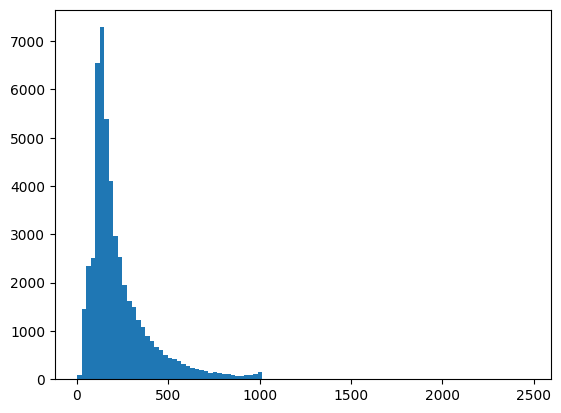

In [12]:
plt.hist(lengths, bins=100);

In [13]:
# What is the min, max and mean lenghts
min_len = min(lengths)
max_len = max(lengths)
mean_len = np.mean(lengths)

print(f"Min length: {min_len}")
print(f"Max lenghth: {max_len}")
print(f"Mean length: {mean_len}")

Min length: 4
Max lenghth: 2470
Mean length: 231.14594


In [14]:
# Preview the sentences of min length
data[data["review"].apply(lambda x: len(x.split(" "))) == min_len]

,review,sentiment
28920,Primary plot!Primary direction!Poor interpreta...,negative


In [15]:
# Preview the sentences of max length
data[data["review"].apply(lambda x: len(x.split(" "))) == min_len]

,review,sentiment
28920,Primary plot!Primary direction!Poor interpreta...,negative


In [16]:
# What is the 95th percentile of lengths
MAX_LEN = np.percentile(lengths, 95).astype("uint64") # This going to be the max length for truncating
MAX_LEN

590

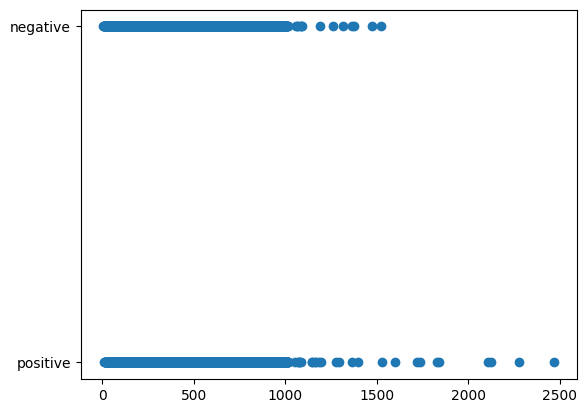

In [17]:
# Does sentiment depenend of review length
plt.scatter(lengths, data["sentiment"]);

# Preprocess the data

In [18]:
X = data["review"]
y = data["sentiment"]

In [19]:
# Remove punctuation and add spaces (some sentences are like this: "Hello!How are you...") Hello!How would be considered one word
def remove_punctuation(text):
    translator = str.maketrans("", "", string.punctuation)
    cleaned_text = text.translate(translator)
    return cleaned_text

# Example usage with a Pandas Series
import pandas as pd

# Assuming 'series' is your Pandas Series containing the text data
X = np.array(X.apply(remove_punctuation))
X[0][:200]


'One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked They are right as this is exactly what happened with mebr br The first thing that struck me about Oz was '

In [20]:
# Split the data into train, val and test datasets
X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(X, y, train_size=0.8)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp_raw, y_temp_raw, train_size=0.5)


X_train_raw.shape, y_train_raw.shape, X_val_raw.shape, y_val_raw.shape, X_test_raw.shape, y_val_raw.shape

((40000,), (40000,), (5000,), (5000,), (5000,), (5000,))

In [21]:
# Tokenize data
VOCAB_SIZE = 15000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train_raw)

In [22]:
tokenizer.texts_to_sequences(["Hello everybody"])

[[5379, 1400]]

## Pad and truncate sequences

In [23]:
def get_sequences(tokenizer, reviews, max_len):
  sequences = tokenizer.texts_to_sequences(reviews)
  padded = pad_sequences(sequences, maxlen=max_len, truncating="post", padding="post")
  return padded

In [24]:
X_train = get_sequences(tokenizer, X_train_raw, MAX_LEN)
X_val = get_sequences(tokenizer, X_val_raw, MAX_LEN)
X_test = get_sequences(tokenizer, X_test_raw, MAX_LEN)

In [25]:
X_train[0][:50]

array([  10,  205,   11,   20, 2589,   29,    5,    2,  149, 3673,    3,
          9, 1329,    1,   16,    4,   80,  783,   12,  265,   46,    5,
          1, 3082,    8, 1255,    5,    2,  430, 1243,   62,    7, 6923,
        453,    3,    1,   13,   10,  195,    2,  115,  444,    8,    2,
         20,   14,  311,  662,  542,  149], dtype=int32)

## Prepare the labels

In [26]:
class_names = set(y)
i_to_name = dict((i, c) for i, c in enumerate(class_names))
name_to_i = dict((v, k) for k, v in i_to_name.items())

i_to_name

{0: 'negative', 1: 'positive'}

In [27]:
# Encode the labels
encode = lambda labels: np.array([name_to_i[x] for x in labels])
y_train = encode(y_train_raw)
y_val = encode(y_val_raw)
y_test = encode(y_test_raw)

y_train[:10]

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1])

# Create tensorflow datasets for better performance

In [28]:
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_val_dataset = tf.data.Dataset.from_tensor_slices(X_val)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)

y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
y_val_dataset = tf.data.Dataset.from_tensor_slices(y_val)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_data = tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
val_data = tf.data.Dataset.zip((X_val_dataset, y_val_dataset))
test_data = tf.data.Dataset.zip((X_test_dataset, y_test_dataset))

In [29]:
train_data = train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE).cache()
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE).cache()
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE).cache()

# Creating models

In [30]:
model0 = Sequential([
    layers.Embedding(VOCAB_SIZE, 32, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model0.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 590, 32)           480000    
                                                                 
 bidirectional (Bidirectiona  (None, 590, 64)          16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              197632    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 760,321
Trainable params: 760,321
Non-trai

In [31]:
# Fit the model
hist = model0.fit(
    train_data,
    epochs=10,
    validation_data=[val_data],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3),
        tf.keras.callbacks.ModelCheckpoint(filepath="model0_best", monitor="val_accuracy", save_weights_only=False, save_best_only=True)
    ]
)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.8160

1250/1250 [==============================] - 266s 202ms/step - loss: 0.4074 - accuracy: 0.8160 - val_loss: 0.3707 - val_accuracy: 0.8398
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9043

1250/1250 [==============================] - 117s 94ms/step - loss: 0.2542 - accuracy: 0.9043 - val_loss: 0.3299 - val_accuracy: 0.8712
Epoch 3/10
1250/1250 [==============================] - 92s 74ms/step - loss: 0.1915 - accuracy: 0.9316 - val_loss: 0.3520 - val_accuracy: 0.8616
Epoch 4/10
1250/1250 [==============================] - 94s 76ms/step - loss: 0.1730 - accuracy: 0.9390 - val_loss: 0.3656 - val_accuracy: 0.8546
Epoch 5/10
1250/1250 [==============================] - 93s 74ms/step - loss: 0.1297 - accuracy: 0.9567 - val_loss: 0.3587 - val_accuracy: 0.8584


In [32]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

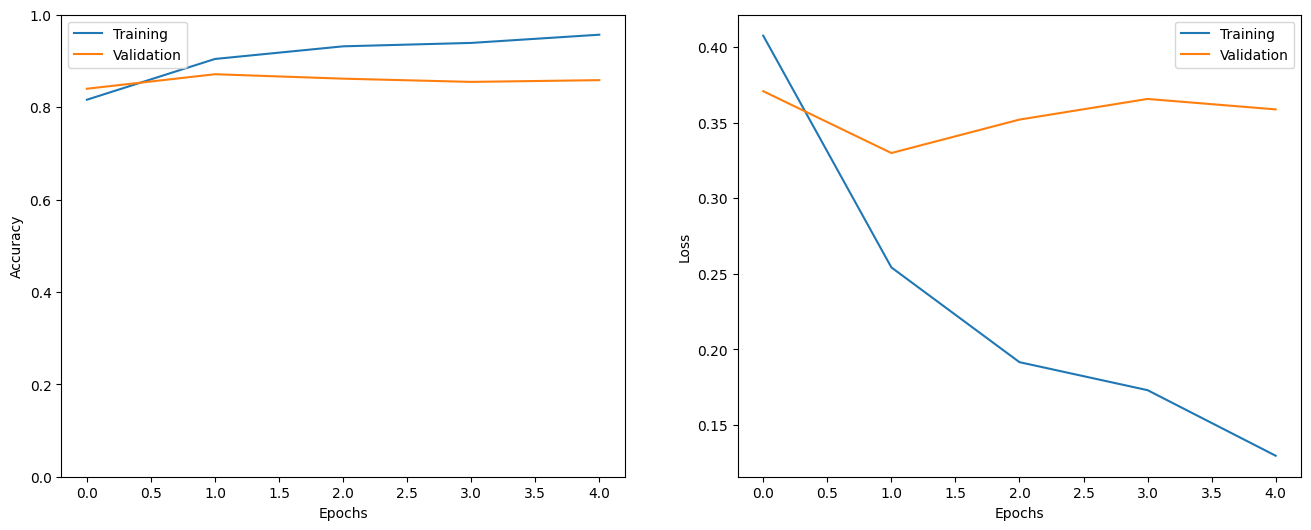

In [34]:
show_history(hist)

In [35]:
best_model = tf.keras.models.load_model("model0_best")

In [36]:
# Evaluate the model
best_model.evaluate(test_data)

157/157 [==============================] - 7s 35ms/step - loss: 0.3178 - accuracy: 0.8812


[0.31783080101013184, 0.8812000155448914]

In [37]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Assuming you have a trained Keras model called `model`
# Assuming you have test data `X_test` and corresponding true labels `y_true`

# Make predictions using the model
y_pred = best_model.predict(test_data)

# Convert predictions to binary labels
y_pred = np.round(y_pred)

# Compute precision, recall, and F1-score
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", fscore)


157/157 [==============================] - 5s 27ms/step
Precision: 0.9108391608391608
Recall: 0.8423605497170574
F1-score: 0.8752624947501051
